# Homework - week 3

https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework/week03

In [1]:
# libraries

import pandas as pd
from sklearn.preprocessing import StandardScaler

import jax.numpy as np
from jax import random

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

import arviz as az

assert numpyro.__version__.startswith('0.7.1')

from plotnine import *
theme_set( theme_seaborn(style='darkgrid'))

import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('bmh')

import arviz as az

from causalgraphicalmodels import CausalGraphicalModel

## Four types of relations in a DAG

In [2]:
fork = CausalGraphicalModel(nodes=["X", "Y", "Z"], edges=[("Z", "X"), ("Z", "Y")])
pipe = CausalGraphicalModel(nodes=["X", "Y", "Z"], edges=[("X", "Z"), ("Z", "Y")])
collider = CausalGraphicalModel(nodes=["X", "Y", "Z"], edges=[("X", "Z"), ("Y", "Z")])
descendent = CausalGraphicalModel(nodes=["X", "Y", "Z", "D"], edges=[("X", "Y"), ("Z", "Y"), ("Y", "D")])

1. Fork

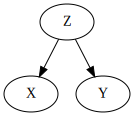

In [3]:
fork.draw()

2. Pipe

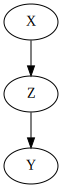

In [4]:
pipe.draw()

3. Collider

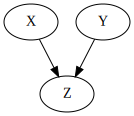

In [5]:
collider.draw()

4. Descendent

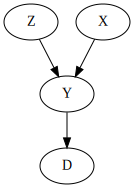

In [6]:
descendent.draw()

## Recepie

1. List all of the paths connecting `X` (potential cuase) and `Y` (outcome).
2. Calssify each path as either open or closed. A path is open unless it contains a collider.
3. Classify each path by whether it is a backdoor path (has an arrow entering `X`)
4. If there are any open backdoor paths, decide which variables to condition on

## Problems

All three problems below are based on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others. We want to model the weight of each fox. For the problems below, assume this DAG:

![](dag.png)

1. Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.
	
    
2. Now infer the causal impact of adding food (avgfood) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?
	
    
3. Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they make sense together?

## Load and prerocess data

In [7]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
print(df.head())
# summarize data
df.describe()

   group  avgfood  groupsize  area  weight
0      1     0.37          2  1.09    5.02
1      1     0.37          2  1.09    2.84
2      2     0.53          2  2.05    5.33
3      2     0.53          2  2.05    6.07
4      3     0.49          2  2.12    5.85


,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


In [8]:
# standardize data
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df)
df.describe()

,group,avgfood,groupsize,area,weight
count,1.160000e+02,1.160000e+02,1.160000e+02,1.160000e+02,1.160000e+02
mean,-4.594026e-17,3.100968e-16,-1.780185e-16,-5.933951e-16,4.153765e-16
std,1.004338e+00,1.004338e+00,1.004338e+00,1.004338e+00,1.004338e+00
min,-2.033956e+00,-1.933180e+00,-1.530701e+00,-2.249313e+00,-2.213621e+00
25%,-6.848372e-01,-4.645220e-01,-8.779020e-01,-6.265396e-01,-6.867840e-01
50%,9.953400e-02,-8.469668e-02,-2.251031e-01,-4.234132e-02,-9.301419e-02
75%,8.525303e-01,2.444853e-01,4.276958e-01,6.527464e-01,7.170575e-01
max,1.605527e+00,2.320864e+00,2.386093e+00,2.056445e+00,2.561985e+00


## Exercise 1: total causal influence of area on weight

`weight` ~ `area`

All paths connecting `area` and `weight`:
1. `area` -> `avgfood` -> `weight`
2. `area` -> `avgfood` -> `groupsize` -> `weight`

Both paths contain no colliders, hence they are open paths. None of the paths contains a backdoor. Let's check:


[]
frozenset({frozenset()})


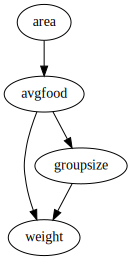

In [9]:
foxes = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)

# draw return a graphviz `dot` object, which jupyter can render
print(foxes.get_all_backdoor_paths("area", "weight"))
print(foxes.get_all_backdoor_adjustment_sets("area", "weight"))
foxes.draw()

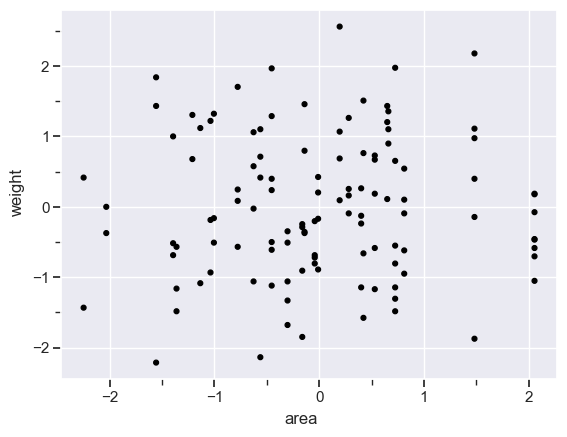

<ggplot: (388435595)>

In [10]:
(
    ggplot(df, aes(x='area', y='weight')) +
    geom_point() 
)

### 1.1 Model

In [11]:
def model(weight=None, area=None):
    
    # priors
    b0 = numpyro.sample('b0', dist.Normal(0,0.2))
    b1 = numpyro.sample('b1', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # deterministic transformation
    mu = numpyro.deterministic("mu", b0 + b1 * area)
    
    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=weight)

### 1.2 Prior predictive check

In [12]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=20)
prior_predictions = prior_predictive(rng_key_, area=df.area.values)

In [13]:
prior_predictions.keys()

dict_keys(['b0', 'b1', 'mu', 'obs', 'sigma'])

[]

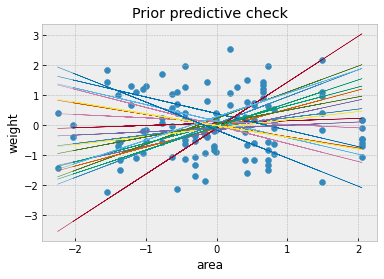

In [14]:
mu = prior_predictions['mu']

for i in range(len(mu)):
    plt.plot(df.area.values, mu[i,:], linewidth=0.5)
plt.title('Prior predictive check')
plt.xlabel('area')
plt.ylabel('weight')
plt.scatter(df.area.values, df.weight.values)
plt.plot()

### 1.3 Inference

In [15]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, area=df.area.values, weight=df.weight.values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████| 3000/3000 [00:02<00:00, 1170.57it/s, 3 steps of size 8.51e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0      0.00      0.09      0.01     -0.14      0.14   1601.93      1.00
        b1      0.02      0.09      0.02     -0.13      0.18   2658.71      1.00
     sigma      1.01      0.07      1.01      0.90      1.12   1816.74      1.00

Number of divergences: 0


Estimates of `b1` are small numbers around 0, so there is no string dependence between `area` and `weight`.

### 1.4 Checking convergence


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0      0.00      0.09      0.01     -0.14      0.14   1601.93      1.00
        b1      0.02      0.09      0.02     -0.13      0.18   2658.71      1.00
     sigma      1.01      0.07      1.01      0.90      1.12   1816.74      1.00

Number of divergences: 0


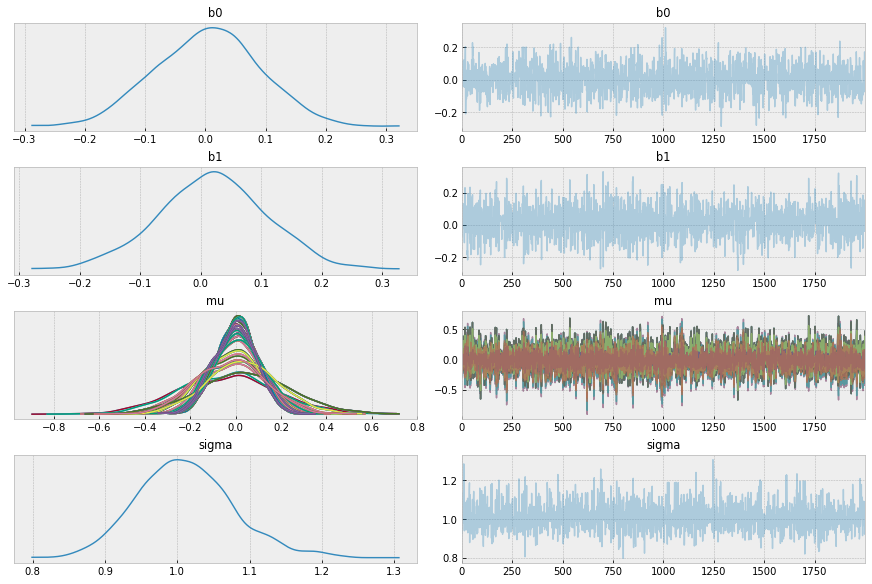

In [16]:
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

### 1.5 Predictions

In [17]:
area_pred = np.linspace(-3, 3, 100)

predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, area=area_pred)['mu']

mean_pred = np.mean(predictions, axis=0)
hpdi_pred = hpdi(predictions, 0.89)

d = {'area_pred': area_pred, 'mean_pred': mean_pred, 'lower': hpdi_pred[0,], 'upper': hpdi_pred[1,]}
df_post = pd.DataFrame(data=d)
df_post.head(3)

,area_pred,mean_pred,lower,upper
0,-3.000000,-0.054703,-0.509627,0.431056
1,-2.939394,-0.053524,-0.501102,0.422054
2,-2.878788,-0.052344,-0.490393,0.415071


In [18]:
def plot_post(df_post, xname, xlab):
    p = (
        ggplot(df_post,aes(x=xname, y='mean_pred')) + 
        geom_point(alpha=0.5) + 
        geom_line(aes(y = 'mean_pred')) + 
        geom_ribbon(aes(ymin='lower',ymax='upper'), fill='dodgerblue', alpha=0.3) +
        labs(x=xlab)
    )
    return p

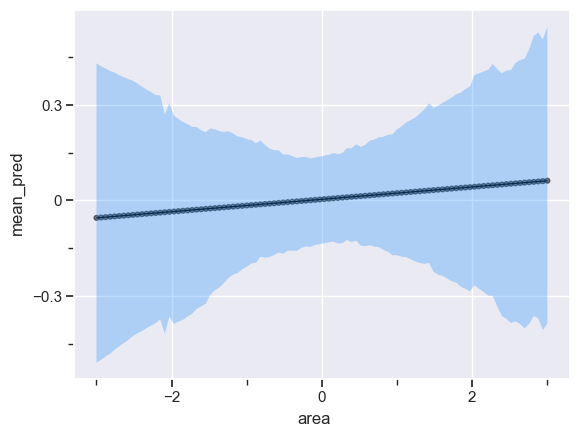

<ggplot: (389513539)>

In [19]:
plot_post(df_post, xname='area_pred', xlab='area')

## Exercise 2: food


`weight` ~ `avgfood`

All paths connecting `weight` and `weight`:
1. `avgfood` -> `weight`
2. `avgfood` -> `groupsize` -> `weight`

Both paths contain no colliders, hence they are open paths. None of the paths contains a backdoor. Let's check


[]
frozenset({frozenset()})


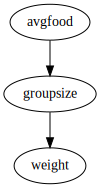

In [20]:
foxes = CausalGraphicalModel(
    nodes=["avgfood", "groupsize", "weight"],
    edges=[
        ("avgfood", "groupsize"),
        ("groupsize", "weight"),
    ],
)

# draw return a graphviz `dot` object, which jupyter can render
print(foxes.get_all_backdoor_paths("avgfood", "weight"))
print(foxes.get_all_backdoor_adjustment_sets("avgfood", "weight"))
foxes.draw()

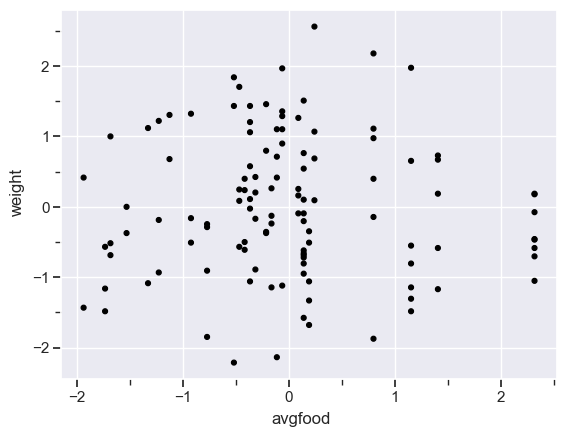

<ggplot: (389475094)>

In [21]:
(
    ggplot(df, aes(x = 'avgfood', y='weight')) + 
    geom_point()
)

In [22]:
def model_food(food=None, weight=None):

    # priors
    b0 = numpyro.sample('b0', dist.Normal(0,0.2))
    b1 = numpyro.sample('b1', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # deterministic transformation
    mu = numpyro.deterministic("mu", b0 + b1 * food)
    
    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=weight)

In [23]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model_food)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, food=df.avgfood.values, weight=df.weight.values)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████| 3000/3000 [00:02<00:00, 1223.19it/s, 7 steps of size 7.11e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -0.00      0.08     -0.00     -0.14      0.13   1470.78      1.00
        b1     -0.03      0.09     -0.03     -0.17      0.13   1956.27      1.00
     sigma      1.01      0.07      1.01      0.90      1.12   1753.60      1.00

Number of divergences: 0


There isn't any strong effect of `avgfood` on weight.

   food_pred  mean_pred     lower     upper
0  -3.000000   0.079506 -0.343710  0.570836
1  -2.939394   0.077899 -0.341847  0.555073
2  -2.878788   0.076292 -0.334149  0.546762


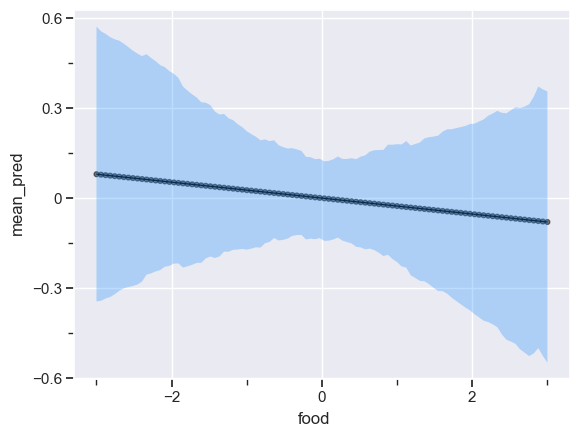

<ggplot: (389071957)>

In [24]:
food_pred = np.linspace(-3, 3, 100)

predictive = Predictive(model_food, samples)
predictions = predictive(rng_key_, food=food_pred)['mu']

mean_pred = np.mean(predictions, axis=0)
hpdi_pred = hpdi(predictions, 0.89)

d = {'food_pred': food_pred, 'mean_pred': mean_pred, 'lower': hpdi_pred[0,], 'upper': hpdi_pred[1,]}
df_post = pd.DataFrame(data=d)
print(df_post.head(3))
plot_post(df_post, xname='food_pred', xlab='food')

## Exercise 3: group size

`weight` ~ `groupsize`

All paths connecting `groupsize` and `weight`:
1. `groupsize` -> `weight`
2. `groupsize` <- `avgfood` -> `weight`

Both paths contain no colliders, hence they are open paths. 

Path 2 contains a backdoor (an arrow entering `groupsize`). There is a fork in this path, which we resolve by conditioning on the counfounder `avgfood`. Let's check:

Backdoor paths:
[['groupsize', 'avgfood', 'weight']]
Backdoor adjustment sets:
frozenset({frozenset({'avgfood'})})


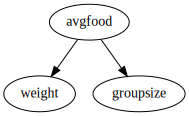

In [25]:
foxes = CausalGraphicalModel(nodes=["groupsize", "weight", "avgfood"], edges=[("avgfood", "groupsize"), ("avgfood", "weight")])

# draw return a graphviz `dot` object, which jupyter can render
print('Backdoor paths:')
print(foxes.get_all_backdoor_paths("groupsize", "weight"))
print('Backdoor adjustment sets:')
print(foxes.get_all_backdoor_adjustment_sets("groupsize", "weight"))
foxes.draw()

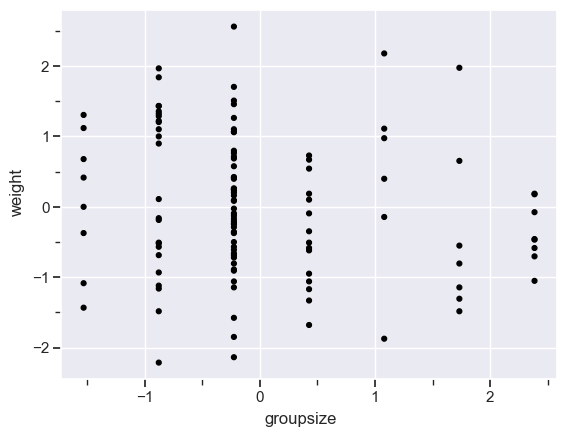

<ggplot: (389062494)>

In [26]:
(
    ggplot(df, aes(x='groupsize', y='weight')) + 
    geom_point()
)

In [27]:
def model_groupsize(groupsize=None, food=None, weight=None):

    # priors
    b0 = numpyro.sample('b0', dist.Normal(0,0.2))
    b1 = numpyro.sample('b1', dist.Normal(0,0.5))
    b2 = numpyro.sample('b2', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # deterministic transformation
    mu = numpyro.deterministic("mu", b0 + b1 * food + b2 * groupsize)
    
    # likelihood
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=weight)

In [29]:
kernel = NUTS(model_groupsize)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key_, groupsize=df.groupsize.values, food=df.avgfood.values, weight=df.weight.values)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|█████| 3000/3000 [00:02<00:00, 1115.26it/s, 15 steps of size 3.17e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -0.00      0.09      0.00     -0.14      0.13   1448.03      1.00
        b1      0.46      0.18      0.46      0.15      0.75   1334.62      1.00
        b2     -0.56      0.18     -0.55     -0.87     -0.26   1353.48      1.00
     sigma      0.97      0.07      0.96      0.86      1.08   1186.50      1.00

Number of divergences: 0


Now the effect of groupsize is negative, while the effect of food is positive. 

## Trying out Laplace approximation

In [85]:
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer import SVI, Trace_ELBO
import numpyro.optim as optim
from numpyro.diagnostics import print_summary

In [89]:
guide = AutoLaplaceApproximation(model_groupsize)
svi = SVI(guide.model, guide, optim.Adam(1), Trace_ELBO(), groupsize=df.groupsize.values, food=df.avgfood.values, weight=df.weight.values)
svi_result = svi.run(rng_key, 5000)
svi_params = svi_result.params
svi_params_posterior = guide.sample_posterior(rng_key, svi_params, (1000,))
pp = guide.sample_posterior(rng_key, svi_params, (1000,))
pp.pop("mu")
print_summary(pp,0.89, False) ## as we have no chains need False

100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2650.59it/s, init loss: 2143.1074, avg. loss [4751-5000]: 160.6930]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        b0      0.00      0.08      0.00     -0.14      0.12   1000.78      1.00
        b1      0.50      0.17      0.51      0.23      0.79    978.03      1.00
        b2     -0.55      0.17     -0.56     -0.85     -0.29    971.14      1.00
     sigma      0.96      0.06      0.96      0.86      1.06    936.03      1.00

